# Cats and Dogs in the Austin Animal Shelter -- Modeling

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import joblib
import time

In [2]:
sns.set_style("darkgrid")
sns.set(font_scale=2)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

# Modeling

First, let's get the final shelter dataframe from the Data Cleaning and Feature Engineering section:

In [4]:
shelter_df = joblib.load('./shelter_df.pkl')

A key point in this analysis is the imbalanced dataset; because this animal shelter is "no-kill", there will be very few euthanasia. In fact, most outcomes for the animals are good (e.g., adopted or returned to owner), and there are very few bad (e.g., euthanasia) outcomes! 

Number of animals with good outcomes: 92252 in percentage: 68.71145538507373
Number of animals with bad outcomes: 4883 in percentage: 3.6369730373901383
Number of animals with neutral outcomes: 37125 in percentage: 27.651571577536124


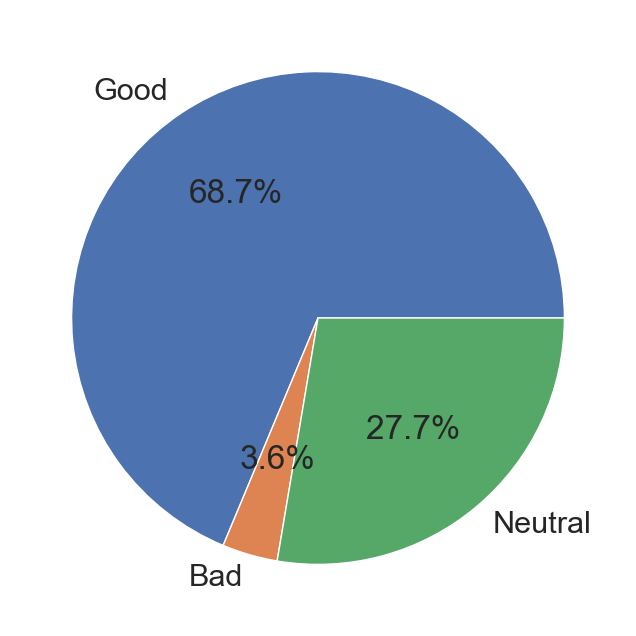

In [52]:
good_count = (shelter_df['outcome']=='good').sum()
bad_count = (shelter_df['outcome']=='bad').sum()
neutral_count = (shelter_df['outcome']=='neutral').sum()
print('Number of animals with good outcomes:', good_count, 'in percentage:', 100*good_count/len(shelter_df))
print('Number of animals with bad outcomes:', bad_count, 'in percentage:', 100*bad_count/len(shelter_df))
print('Number of animals with neutral outcomes:', neutral_count, 'in percentage:', 100*neutral_count/len(shelter_df))

fig = plt.figure(figsize=(8,8))
plt.pie([good_count,bad_count,neutral_count], labels=['Good','Bad','Neutral'], autopct='%1.1f%%')
plt.savefig('imbalance_dataset', bbox_inches='tight')
plt.show()

We will use two models, random forest and gradient boosted trees. We will also try multiple methods for dealing with the imbalanced dataset!

## Random forest

Our strategy with applying random forest on this imbalanced dataset is the following:
1) Rebalance or weight the data
2) Perform grid-search cross-validation to find the optimal random forest parameters
3) Compare the weighted f1 score between the different rebalance/data-weighting schemes to find the best model

In [6]:
# Define features
feature_columns = ['stay_length_days','intake_type','intake_condition','animal_type', 
                   'intake_sex', 'outcome_sex', 'intake_age_years', 'mult', 
                   'breed', 'color', 'intake_day', 'intake_month']
categorical_cols = ['intake_type','intake_condition','animal_type', 
                   'intake_sex', 'outcome_sex', 'breed', 'color','mult', 'intake_day', 'intake_month']
X_all = shelter_df[feature_columns]
y_all = shelter_df['outcome']

# Create holdout set
X, X_holdout, y, y_holdout = train_test_split(X_all, y_all, test_size=0.2, random_state=1)

In [7]:
grid_scoring = 'f1_weighted'

### Oversampling with SMOTENC

Our first rebalancing technique is to use SMOTENC (Synthetic Minority Over-sampling Technique for Nominal and Continuous). This oversampling algorithm creates synthetic data for the minority group, and is an extension of SMOTE that allows for categorical features. 

In [8]:
redo_SMOTENC = True

In [9]:
if redo_SMOTENC:

    # Convert categorical cols to indexes (as needed for SMOTENC)
    cat_index = [feature_columns.index(item) for item in feature_columns if item in categorical_cols]

    # Class rebalancing with SMOTENC
    start_time = time.time()
    smote_nc = SMOTENC(categorical_features=cat_index, random_state=1)
    X_resampled, y_resampled = smote_nc.fit_resample(X, y)
    stop_time = time.time()
    print(f"Rebalancing time: {stop_time - start_time}s")
    
    SMOTENC_resampled_Xy = (X_resampled, y_resampled)
    joblib.dump(SMOTENC_resampled_Xy, './SMOTENC_resampled_Xy.pkl') 

else: 
    SMOTENC_resampled_Xy = joblib.load('./SMOTENC_resampled_Xy.pkl')
    X_resampled = SMOTENC_resampled_Xy[0]
    y_resampled = SMOTENC_resampled_Xy[1]
    
# One-hot encoding
X_resampled_encoded = pd.get_dummies(X_resampled, columns=categorical_cols)
y_resampled.value_counts()

Rebalancing time: 25.639467239379883s


outcome
good       73682
neutral    73682
bad        73682
Name: count, dtype: int64

In [10]:
if redo_SMOTENC:

    start_time = time.time()
    param_grid = {
        'n_estimators': [100, 250, 500],
        'criterion' :['gini', 'entropy']
    }
    rfc = RandomForestClassifier(random_state=1)
    grid_search_SMOTENC = GridSearchCV(rfc, param_grid, cv=5, scoring=grid_scoring, 
                                       return_train_score=True)
    grid_search_SMOTENC.fit(X_resampled_encoded, y_resampled)
    stop_time = time.time()

    print(f"Training time: {stop_time - start_time}s")

    joblib.dump(grid_search_SMOTENC, './rf_smote.pkl') 
    
else:
    grid_search_SMOTENC = joblib.load('./rf_smote.pkl')

Training time: 3531.1205797195435s


In [11]:
grid_search_SMOTENC

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [100, 250, 500]},
             return_train_score=True, scoring='f1_weighted')

In [12]:
results_SMOTENCH = pd.DataFrame(grid_search_SMOTENC.cv_results_)
results_SMOTENCH.sort_values(by='rank_test_score', ascending=False, inplace=True)
results_SMOTENCH.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,34.295646,0.477454,1.358548,0.024751,gini,100,"{'criterion': 'gini', 'n_estimators': 100}",0.858094,0.872238,0.931357,...,0.905275,0.033081,6,0.999989,0.999994,0.999994,0.999994,0.999994,0.999993,0.000002
3,33.294797,0.416699,1.273132,0.015859,entropy,100,"{'criterion': 'entropy', 'n_estimators': 100}",0.858985,0.873689,0.930189,...,0.905828,0.032625,5,0.999994,0.999994,0.999989,0.999994,0.999989,0.999992,0.000003
1,85.463563,1.229086,3.125755,0.079452,gini,250,"{'criterion': 'gini', 'n_estimators': 250}",0.859625,0.873536,0.932607,...,0.906693,0.033067,4,1.000000,0.999994,0.999994,1.000000,0.999994,0.999997,0.000003
4,82.960339,1.118706,2.886103,0.041344,entropy,250,"{'criterion': 'entropy', 'n_estimators': 250}",0.859933,0.874026,0.932609,...,0.906992,0.033011,3,1.000000,0.999994,0.999994,1.000000,0.999994,0.999997,0.000003
2,169.641491,3.217833,6.605090,0.180336,gini,500,"{'criterion': 'gini', 'n_estimators': 500}",0.860176,0.874671,0.932838,...,0.907197,0.032821,2,1.000000,0.999994,0.999994,1.000000,0.999994,0.999997,0.000003


In [13]:
print("Best parameters: ", grid_search_SMOTENC.best_params_)
print("Best score: ", grid_search_SMOTENC.best_score_)

Best parameters:  {'criterion': 'entropy', 'n_estimators': 500}
Best score:  0.9075732277016947


Now, we have to test this model on the holdout set.

In [14]:
# One-hot encoding the holdout set
X_holdout_encoded = pd.get_dummies(X_holdout, columns=categorical_cols)

# Make sure the columns in X_houldout_encoded and X_resampled_encoded matches
missing_cols = set(X_resampled_encoded.columns) - set(X_holdout_encoded.columns)
for col in missing_cols:
    X_holdout_encoded[col] = 0
X_holdout_encoded = X_holdout_encoded[X_resampled_encoded.columns]

In [15]:
y_pred = grid_search_SMOTENC.predict(X_holdout_encoded)
conf_matrix = confusion_matrix(y_holdout, y_pred)
print(conf_matrix)
print(classification_report(y_holdout, y_pred))

[[  424   249   297]
 [  324 16941  1305]
 [  457  2240  4615]]
              precision    recall  f1-score   support

         bad       0.35      0.44      0.39       970
        good       0.87      0.91      0.89     18570
     neutral       0.74      0.63      0.68      7312

    accuracy                           0.82     26852
   macro avg       0.66      0.66      0.65     26852
weighted avg       0.82      0.82      0.82     26852



### Undersampling with RandomUnderSampler

Our next rebalancing technique is to undersample the majority groups. This technique is much faster than SMOTENC, but come at the cost of greatly reducing our sample size.

In [16]:
redo_undersample = False

In [17]:
if redo_undersample:
    # Undersample
    start_time = time.time()
    rus = RandomUnderSampler(random_state=1)
    X_undersampled, y_undersampled = rus.fit_resample(X, y)
    stop_time = time.time()
    print(f"Rebalancing time: {stop_time - start_time}s")
    
    undersampled_Xy = (X_undersampled, y_undersampled)
    joblib.dump(undersampled_Xy, './undersampled_Xy.pkl') 

else: 
    undersampled_Xy = joblib.load('./undersampled_Xy.pkl')
    X_undersampled = undersampled_Xy[0]
    y_undersampled = undersampled_Xy[1]
    
# One-hot encoding
X_undersampled_encoded = pd.get_dummies(X_undersampled, columns=categorical_cols)
y_undersampled.value_counts()

outcome
bad        3907
good       3907
neutral    3907
Name: count, dtype: int64

In [18]:
if redo_undersample:

    start_time = time.time()
    param_grid = {
        'n_estimators': [100, 250, 500],
        'criterion' :['gini', 'entropy']
    }
    rfc = RandomForestClassifier(random_state=1)
    grid_search_undersample = GridSearchCV(rfc, param_grid, cv=5, scoring=grid_scoring,return_train_score=True)
    grid_search_undersample.fit(X_undersampled_encoded, y_undersampled)
    stop_time = time.time()

    print(f"Training time: {stop_time - start_time}s")

    joblib.dump(grid_search_undersample, './rf_RandomUnderSampler.pkl') 
    
else:
    grid_search_undersample = joblib.load('./rf_RandomUnderSampler.pkl')

In [19]:
results_undersample = pd.DataFrame(grid_search_undersample.cv_results_)
results_undersample.sort_values(by='rank_test_score', ascending=False, inplace=True)
results_undersample.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,2.411891,0.053052,0.119379,0.003691,gini,250,"{'criterion': 'gini', 'n_estimators': 250}",0.698713,0.688600,0.677052,...,0.686186,0.007503,6,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,1.071335,0.031633,0.051283,0.000702,entropy,100,"{'criterion': 'entropy', 'n_estimators': 100}",0.699466,0.684733,0.680107,...,0.686319,0.006954,5,1.0,1.0,1.0,1.0,1.0,1.0,0.0
0,0.990844,0.033383,0.053023,0.001603,gini,100,"{'criterion': 'gini', 'n_estimators': 100}",0.695382,0.693534,0.674193,...,0.686340,0.007711,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,5.247021,0.019519,0.219779,0.001666,entropy,500,"{'criterion': 'entropy', 'n_estimators': 500}",0.695619,0.691689,0.678970,...,0.688439,0.005527,3,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,4.792621,0.075948,0.224949,0.006898,gini,500,"{'criterion': 'gini', 'n_estimators': 500}",0.699680,0.692347,0.679241,...,0.689179,0.006890,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [20]:
print("Best parameters: ", grid_search_undersample.best_params_)
print("Best score: ", grid_search_undersample.best_score_)

Best parameters:  {'criterion': 'entropy', 'n_estimators': 250}
Best score:  0.6896500734008228


Now we test this model on the holdout set.

In [21]:
# One-hot encoding the holdout set
X_holdout_encoded = pd.get_dummies(X_holdout, columns=categorical_cols)

# Make sure the columns in X_houldout_encoded and X_undersampled_encoded matches
missing_cols = set(X_undersampled_encoded.columns) - set(X_holdout_encoded.columns)
for col in missing_cols:
    X_holdout_encoded[col] = 0
X_holdout_encoded = X_holdout_encoded[X_undersampled_encoded.columns]

In [22]:
# Test this on the holdout set
y_pred = grid_search_undersample.predict(X_holdout_encoded)
conf_matrix = confusion_matrix(y_holdout, y_pred)
print(conf_matrix)
print(classification_report(y_holdout, y_pred))

[[  896    37    37]
 [ 1348 15429  1793]
 [ 1092  1713  4507]]
              precision    recall  f1-score   support

         bad       0.27      0.92      0.42       970
        good       0.90      0.83      0.86     18570
     neutral       0.71      0.62      0.66      7312

    accuracy                           0.78     26852
   macro avg       0.63      0.79      0.65     26852
weighted avg       0.82      0.78      0.79     26852



### With class weights

Finally, we can use class weights on the random forest algorithm instead of resampling the training set.

In [23]:
redo_class_weights = True

In [24]:
# One-hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_cols)

In [25]:
if redo_class_weights:
    start_time = time.time()
    param_grid = {
        'n_estimators': [100, 250, 500],
        'criterion' :['gini', 'entropy']
    }
    rfc = RandomForestClassifier(random_state=1, class_weight='balanced')
    grid_search_class_weights = GridSearchCV(rfc, param_grid, cv=5, scoring=grid_scoring,
                                             return_train_score=True)
    grid_search_class_weights.fit(X_encoded, y)
    stop_time = time.time()

    print(f"Training time: {stop_time - start_time}s")

    joblib.dump(grid_search_class_weights, './rf_ClassWeights.pkl') 
    
else:
    grid_search_class_weights = joblib.load('./rf_ClassWeights.pkl')

Training time: 1640.036789894104s


In [26]:
results_class_weights = pd.DataFrame(grid_search_class_weights.cv_results_)
results_class_weights.sort_values(by='rank_test_score', ascending=False, inplace=True)
results_class_weights.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,15.585439,0.091695,0.594073,0.012764,gini,100,"{'criterion': 'gini', 'n_estimators': 100}",0.824391,0.825691,0.823475,...,0.823503,0.001460,6,0.999977,0.999977,0.999977,0.999988,0.999965,0.999977,0.000007
3,15.860095,0.106860,0.575302,0.005491,entropy,100,"{'criterion': 'entropy', 'n_estimators': 100}",0.824285,0.826321,0.823602,...,0.823555,0.001925,5,0.999988,0.999988,0.999965,0.999977,0.999953,0.999974,0.000014
4,39.393146,0.093909,1.306415,0.009625,entropy,250,"{'criterion': 'entropy', 'n_estimators': 250}",0.823957,0.827294,0.824079,...,0.824113,0.001854,4,0.999988,0.999988,1.000000,1.000000,0.999988,0.999993,0.000006
2,77.184017,0.265712,2.608884,0.014219,gini,500,"{'criterion': 'gini', 'n_estimators': 500}",0.825981,0.827875,0.823310,...,0.824484,0.002186,3,0.999988,0.999988,1.000000,1.000000,0.999988,0.999993,0.000006
1,38.576123,0.086999,1.344889,0.005131,gini,250,"{'criterion': 'gini', 'n_estimators': 250}",0.825653,0.827066,0.824004,...,0.824509,0.001754,2,0.999988,0.999988,1.000000,1.000000,0.999988,0.999993,0.000006


In [27]:
print("Best parameters: ", grid_search_class_weights.best_params_)
print("Best score: ", grid_search_class_weights.best_score_)

Best parameters:  {'criterion': 'entropy', 'n_estimators': 500}
Best score:  0.8246519908391514


Now we test this model on the holdout set.

In [28]:
# One-hot encoding the holdout set
X_holdout_encoded = pd.get_dummies(X_holdout, columns=categorical_cols)

# Make sure the columns in X_houldout_encoded and X_encoded matches
missing_cols = set(X_encoded.columns) - set(X_holdout_encoded.columns)
for col in missing_cols:
    X_holdout_encoded[col] = 0
X_holdout_encoded = X_holdout_encoded[X_encoded.columns]

In [29]:
# Test this on the holdout set
y_pred = grid_search_class_weights.predict(X_holdout_encoded)
conf_matrix = confusion_matrix(y_holdout, y_pred)
print(conf_matrix)
print(classification_report(y_holdout, y_pred))

[[  231   355   384]
 [   41 17770   759]
 [  106  2686  4520]]
              precision    recall  f1-score   support

         bad       0.61      0.24      0.34       970
        good       0.85      0.96      0.90     18570
     neutral       0.80      0.62      0.70      7312

    accuracy                           0.84     26852
   macro avg       0.75      0.60      0.65     26852
weighted avg       0.83      0.84      0.83     26852



Comparing the three random forest models (which differs based on how we handle the data imbalances), the one with the best weighted f1-score is class-weights with a weighted f1 of 0.83. This is very slightly greater than the weighted f1-score of SMOTENC (0.82) and markedly better than the weighted f1-score of random undersample (0.79). 

However, the f1-score of the "bad" outcome for class-weights (0.34) is significantly worse than SMOTENC (0.39) and random undersample (0.42), owing to class-weights having poor recall for "bad" oucomes (0.24). As identifying the bad outcomes correctly is important in this problem, I do not think that the slight increase of 0.01 point in weighted f1-score in using the class-weights instead of SMOTENC is worth it. Thus, I will declare our best random forest model to be the SMOTENC model. 

## Gradient boosted trees

Next, we will also model the dataset with gradient boosted trees. We can compare its performance with the random forest models at the end to obtain our final model.

In order to handle the imbalanced dataset, we can weigh the classes according to their population. We will try XGBoost both with and without class weights. As with the random forest models, we will find the optimal XGBoost parameters by performing grid-search cross-validation.

In [30]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight

In [31]:
# xgboost requires y to be coded
le = LabelEncoder()
y_coded = le.fit_transform(y)
y_holdout_coded = le.fit_transform(y)

In [32]:
# xgboost has support for categorical columns without encoding for 
# tree_method being `gpu_hist`, `approx`, or `hist`
# To use it, we have to change the data type of the categorical columns to "category"
tree_method="hist" # this is the tree method used by LightGBM
X[categorical_cols] = X[categorical_cols].astype("category")
X_holdout[categorical_cols] = X_holdout[categorical_cols].astype("category")

### Without class weights

In [33]:
redo_grid_search_XGB = True

In [34]:
# without class weight
if redo_grid_search_XGB:
    start_time = time.time()
    
    model_xgboost = xgb.XGBClassifier(objective= 'multi:softmax',seed=1,
                                  enable_categorical=True, tree_method=tree_method,
                                  )
    param_grid = {
                    'max_depth': range (2, 10, 1),
                    'n_estimators': range(60, 220, 40),
                    'learning_rate': [0.1, 0.01, 0.05]
                }
    
    grid_search_xgboost = GridSearchCV(model_xgboost, param_grid, cv=5, 
                                    scoring=grid_scoring,return_train_score=True
                                      )
    grid_search_xgboost.fit(X,y_coded)
    stop_time = time.time()

    print(f"Training time: {stop_time - start_time}s")

    joblib.dump(grid_search_xgboost, './xgb_unweighted.pkl') 
    
else:
    grid_search_xgboost = joblib.load('./xgb_unweighted.pkl')

Training time: 1143.9992558956146s


In [35]:
results_grid_search_xgboost = pd.DataFrame(grid_search_xgboost.cv_results_)
results_grid_search_xgboost.sort_values(by='rank_test_score', ascending=False, inplace=True)
results_grid_search_xgboost.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
32,0.477356,0.028222,0.028991,0.000624,0.01,2,60,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.772519,0.777409,...,0.773073,0.002412,96,0.774143,0.770257,0.773875,0.774150,0.773801,0.773245,0.001501
33,0.725204,0.017768,0.035951,0.001040,0.01,2,100,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.773071,0.779176,...,0.773729,0.002936,95,0.774537,0.772467,0.774009,0.774421,0.774105,0.773908,0.000746
34,1.046507,0.083301,0.043055,0.002165,0.01,2,140,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.773029,0.780001,...,0.774246,0.002991,94,0.774938,0.772895,0.774896,0.774947,0.774377,0.774411,0.000787
35,1.233947,0.014922,0.048415,0.001321,0.01,2,180,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.774034,0.780493,...,0.774880,0.002955,93,0.775643,0.773306,0.775713,0.775831,0.775245,0.775148,0.000942
64,0.468561,0.005221,0.031611,0.001468,0.05,2,60,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est...",0.787269,0.790346,...,0.786723,0.002025,92,0.787298,0.786708,0.788531,0.787763,0.786935,0.787447,0.000649


In [36]:
print("Best parameters: ", grid_search_xgboost.best_params_)
print("Best score: ", grid_search_xgboost.best_score_)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 180}
Best score:  0.8292196273335929


In [37]:
# Test this on the holdout set
y_pred = grid_search_xgboost.predict(X_holdout)
# reverse label encoder
y_pred = le.inverse_transform(y_pred)
conf_matrix = confusion_matrix(y_holdout, y_pred)
print(conf_matrix)
print(classification_report(y_holdout, y_pred))

[[  315   291   364]
 [  294 17044  1232]
 [  650  2346  4316]]
              precision    recall  f1-score   support

         bad       0.25      0.32      0.28       970
        good       0.87      0.92      0.89     18570
     neutral       0.73      0.59      0.65      7312

    accuracy                           0.81     26852
   macro avg       0.62      0.61      0.61     26852
weighted avg       0.81      0.81      0.80     26852



### With class weights

In [38]:
redo_grid_search_XGB_weighted = True

In [39]:
# with class weight
sample_weights = compute_sample_weight(class_weight='balanced',y=y)

if redo_grid_search_XGB_weighted:
    start_time = time.time()
    
    model_xgboost_weighted = xgb.XGBClassifier(objective= 'multi:softmax',seed=1,
                                  enable_categorical=True, tree_method=tree_method,
                                  )
    param_grid = {
                    'max_depth': range (2, 10, 1),
                    'n_estimators': range(60, 220, 40),
                    'learning_rate': [0.1, 0.01, 0.05]
                }
    
    grid_search_xgboost_weighted = GridSearchCV(model_xgboost_weighted, param_grid, cv=5, 
                                    scoring=grid_scoring,return_train_score=True
                                      )
    grid_search_xgboost_weighted.fit(X,y_coded, sample_weight=sample_weights)
    stop_time = time.time()

    print(f"Training time: {stop_time - start_time}s")

    joblib.dump(grid_search_xgboost_weighted, './xgb_weighted.pkl') 
    
else:
    grid_search_xgboost_weighted = joblib.load('./xgb_weighted.pkl')

Training time: 1222.0876150131226s


In [40]:
results_grid_search_XGB_weighted = pd.DataFrame(grid_search_xgboost_weighted.cv_results_)
results_grid_search_XGB_weighted.sort_values(by='rank_test_score', ascending=False, inplace=True)
results_grid_search_XGB_weighted.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
40,0.774386,0.040646,0.042673,0.001219,0.01,4,60,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.758338,0.766584,...,0.760521,0.003362,96,0.764898,0.761998,0.765167,0.761188,0.760762,0.762803,0.001865
36,0.626715,0.010505,0.035786,0.001377,0.01,3,60,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.764803,0.769490,...,0.764467,0.003112,95,0.765361,0.762800,0.766567,0.765949,0.764194,0.764974,0.001339
68,0.627324,0.013103,0.039648,0.000685,0.05,3,60,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.763546,0.769892,...,0.764508,0.003449,94,0.767887,0.763082,0.767375,0.767290,0.765824,0.766292,0.001746
41,1.196183,0.019801,0.058941,0.002520,0.01,4,100,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.761799,0.769826,...,0.764630,0.003342,93,0.767672,0.766235,0.769055,0.766690,0.767140,0.767358,0.000973
37,0.993018,0.014998,0.045207,0.000646,0.01,3,100,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.765422,0.771978,...,0.764960,0.004169,92,0.765748,0.764979,0.765687,0.766471,0.764749,0.765527,0.000612


In [41]:
print("Best parameters: ", grid_search_xgboost_weighted.best_params_)
print("Best score: ", grid_search_xgboost_weighted.best_score_)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 180}
Best score:  0.8155304458655668


In [42]:
# Test this on the holdout set
y_pred = grid_search_xgboost_weighted.predict(X_holdout)
# reverse label encoder
y_pred = le.inverse_transform(y_pred)
conf_matrix = confusion_matrix(y_holdout, y_pred)
print(conf_matrix)
print(classification_report(y_holdout, y_pred))

[[  375   240   355]
 [  299 16489  1782]
 [  479  2021  4812]]
              precision    recall  f1-score   support

         bad       0.33      0.39      0.35       970
        good       0.88      0.89      0.88     18570
     neutral       0.69      0.66      0.67      7312

    accuracy                           0.81     26852
   macro avg       0.63      0.64      0.64     26852
weighted avg       0.81      0.81      0.81     26852



The weighted f1-score for the two XGBoost models (0.8 without class-weights) and (0.81 with class-weights) are smaller than our best random forest model (SMOTENC with weighted f1-score of 0.82), so our best overall model is the random forest model with SMOTENC. 

# Feature importances 

We will take our best model and compute the permutation feature importance. First, let us package our best model into a pipeline.

In [43]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [44]:
best_model = grid_search_SMOTENC.best_estimator_
non_categorical_cols = list(set(feature_columns) - set(categorical_cols))

categorical_encoder = OneHotEncoder(handle_unknown='ignore')
#numerical_pipe = SimpleImputer(strategy="mean")
preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_cols),
 #       ("num", numerical_pipe, non_categorical_cols),
    ],
    verbose_feature_names_out=False, remainder='passthrough'
)

best_pipe = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", best_model),
    ]
)

start_time = time.time()
best_pipe.fit(X_resampled, y_resampled)
stop_time = time.time()

print(f"fitting time: {stop_time - start_time}s")

fitting time: 1401.2043750286102s


In [45]:
X_holdout.columns

Index(['stay_length_days', 'intake_type', 'intake_condition', 'animal_type',
       'intake_sex', 'outcome_sex', 'intake_age_years', 'mult', 'breed',
       'color', 'intake_day', 'intake_month'],
      dtype='object')

In [46]:
y_pred = best_pipe.predict(X_holdout)
conf_matrix = confusion_matrix(y_holdout, y_pred)
print(conf_matrix)
print(classification_report(y_holdout, y_pred))

[[  433   248   289]
 [  328 16910  1332]
 [  464  2215  4633]]
              precision    recall  f1-score   support

         bad       0.35      0.45      0.39       970
        good       0.87      0.91      0.89     18570
     neutral       0.74      0.63      0.68      7312

    accuracy                           0.82     26852
   macro avg       0.66      0.66      0.66     26852
weighted avg       0.82      0.82      0.82     26852



In [47]:
from sklearn.inspection import permutation_importance

Computing importances time: 386.3926270008087s


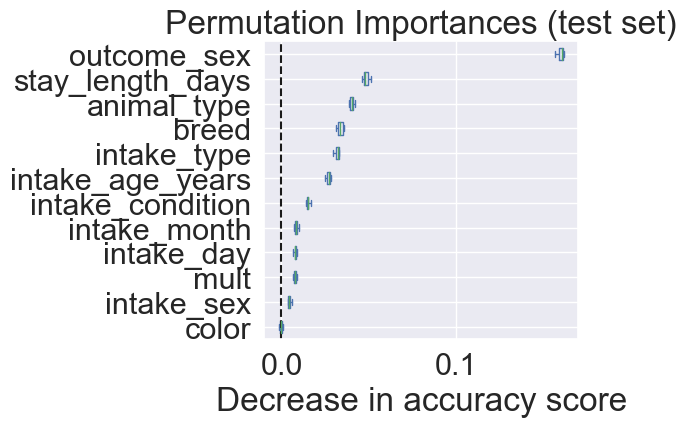

In [50]:
start_time = time.time()

result = permutation_importance(
    best_pipe, X_holdout, y_holdout, n_repeats=10, random_state=1
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

stop_time = time.time()

print(f"Computing importances time: {stop_time - start_time}s")

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.savefig('permutation_importance', bbox_inches='tight')

The permutation importance plot reveals that the top three features that are most important are:

1) outcome_sex: in addition to male/female, the "outcome_sex" feature records whether the animal has been spayed/neutered at the time of outcome. There are two reasons of why this feature might be the one that is most important. First, animals that are already spayed/neutered are more attractive to adopters as spaying/neutering costs money to do. The second reason is that the "good" outcome include "return_to_owner", indicating that they are lost pets instead of wild animals, and most pet cats/dogs in the US are spayed/neutered. 

2) stay_length_days: this feature records the length of time the animal is in the shelter. A lost pet is quickly picked up by their owners, resulting in a good outcome within a short amount of time. 

3) animal_type: indicates cats vs dogs. It turns out that dogs are slightly (about 5% more) more favored to have good outcome than cats.